# Create Demo Data


To create fake PII data, we use the source code from socrates for simulation: https://github.com/Lattice-Works/Socrates-dev/tree/master/resources

(git clone butterfingers and socrates-dev, and `python setup.py install` in butterfingers and then in `Socrates-dev/resources/simulator/participant_generator/source`

(install both butter-fingers and simulator, and a few other dependencies as needed)

In [1]:
from participantgenerator.tablegenerator import subjectgenerator
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import sqlalchemy
import openlattice
import uuid

Display all columns and make columns fill width of browser

In [150]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.set_option('display.max_columns', None)
pd.set_option('expand_frame_repr', True)
pd.set_option('display.max_rows', 500)
pd.set_option('display.width', 1000)
pd.set_option('colheader_justify', 'left')

Define probabilities in demodata

In [3]:
typoness = {
    "firstName": 0.01,
    "middleName": 0.01,
    "lastName": 0.01,
    "ssn": 0,
    "sex": 0.01,
    "dob": 0,
    "race": 0.01,
    "ethnicity": 0.01        
}
missingness = {
    "firstName": 0,
    "middleName": 0,
    "lastName": 0,
    "ssn": 0.1,
    "sex": 0.1,
    "dob": 0,
    "race": 0.1,
    "ethnicity": 0.1
}

# from 2018 census
education_dict = {
    "Elementary or High school, no diploma": 14.2/100,
    "9th grade, no diploma": 7./100,
    "10th grade, no diploma": 7./100,
    "11th grade, no diploma": 7./100,
    "12th grade, no diploma": 4.4/100,
    'Elementary or High school, GED': 28.5/100,
    'High school diploma': 20.5/100,
    "Postsecondary/Some College": 11.4/100
}

# based on customer probabilities > 0.01
reason_dict = {
    'OFA': 0.27,
    'WFA': 0.25,
    'VIEW': 0.17,
    'MO': 0.16,
    'CO': 0.05,
    'PR': 0.03,
    'WRIT': 0.02,
    'BS': 0.01,
    'CIT': 0.01,
    'SENT': 0.01,
    'SWK': 0.01,
    'TC': 0.01}

facility_dict = {
    "SomeJail": 0.25,
    "AnyJail": 0.25,
    "AnotherJail": 0.25,
    "CountyJail": 0.25
}

gender_dict = {
    'Male': 0.650, 
    "Female": 0.1, 
    "Non-Binary": 0.02, 
    "Transgender (Male to Female)": 0.02, 
    "Transgender (Female to Male)": 0.02, 
    "Other": 0.03, 
    "Unknown": 0.02, 
    "Decline to State": 0.12, 
    "Not Asked":0.02
}

marital_dict = {
    'Single': 0.3 , 
    'Married': 0.3, 
    'Widowed': 0.1, 
    'Separated': 0.05, 
    'Divorced': 0.15, 
    'Domestic Partner': 0.05, 
    'Common Law': 0.05
}

In [4]:
# function to get a random date in a predefined year
def random_date_in_year(year):
    startyear = datetime.strptime('1/1/%s 00:00'%year, '%m/%d/%Y %H:%M')
    secondsinyear = 365*24*60*60
    seconds_from_newyear = np.random.randint(low = 0, high = secondsinyear)
    date = startyear + timedelta(seconds = seconds_from_newyear)
    return date

## Explore Existing Datasets

In [5]:
existing_demohealth = pd.read_csv('demo_health.csv')
existing_demojustice = pd.read_csv('demo_justice.csv')

cols in person in demojail - name_id, firstName, lastName, middleName, sex, race, ethnicity, dob, ssn

cols in person in pateints - ID, GivenName, Surname, Sex, Race, Ethnicity, Birthdate, FacilityName

persondetails - eyecolor, maritalstatus, militarystatus

## People Data

In [6]:
peopledictlist = []

for i in range(100):
    # generate person
    subject = subjectgenerator.subject()
    subject.generate()
    variant = subject.create_variant(typoness, missingness,0 ,0)
    variant['education'] = np.random.choice(list(education_dict.keys()), p = list(education_dict.values()))
    variant['name_id'] = str(uuid.uuid1())
    variant['gender'] = np.random.choice(list(gender_dict.keys()), p = list(gender_dict.values()))

    roughage = int(datetime.today().strftime('%Y')) - int(variant['dob'][:4])
    
    # generate persondetails
    variant['maritalstatus'] =  np.random.choice(list(marital_dict.keys()), p = list(marital_dict.values())) \
        if roughage > 20 else "Single"
    
    
    # generate persondetails sexoffender
    variant['sexoffender'] = np.random.choice(["Y", "N"], p = [0.4, 0.6]) if \
        roughage > 20 else np.random.choice(["Y", "N"], p = [0.4, 0.6])
    
    peopledictlist.append(variant)

In [7]:
demopeople = pd.DataFrame(peopledictlist)
demopeople.sample(5)

,firstName,lastName,middleName,sex,ssn,dob,race,ethnicity,education,name_id,gender,maritalstatus,sexoffender
55,James,Romero,Joseph,M,731-72-8730,2000-10-22,White,Hispanic,High school diploma,c1d38eea-42c7-11ea-8c4d-acde48001122,Male,Single,N
19,Qlizabeth,Horn,Howard,F,471-64-5888,1993-05-15,Other,,"Elementary or High school, GED",c17d672c-42c7-11ea-8c4d-acde48001122,Male,Common Law,N
5,Alla,Bueler,D,M,085-10-3351,1986-05-05,Xhite,Hispanic,"Elementary or High school, GED",c1599c3e-42c7-11ea-8c4d-acde48001122,Male,Widowed,N
62,Doris,Drennen,P,M,543-16-1178,1952-04-01,Black,Non-Hispanic,"10th grade, no diploma",c1de213e-42c7-11ea-8c4d-acde48001122,Decline to State,Divorced,Y
14,Charles,Nase,W,F,824-71-4321,1990-07-20,,Hispanic,Postsecondary/Some College,c1748b98-42c7-11ea-8c4d-acde48001122,Male,Married,N


## Jail Data

In [8]:
jaildictlist = []

for i in range(100):
    jailvariant = {}
    bkyear = np.random.randint(low = 12, high = 19)
    bkdate = random_date_in_year(2000+bkyear)
    sentencelengthdays = np.random.randint(low = 0, high = (30 - bkyear)*365)
    reldate = bkdate + timedelta(days = sentencelengthdays)
    
    ageatbooking = int((bkdate - datetime.strptime(variant['dob'], "%Y-%m-%d")).days/365)


    # generate jailstay
    jailvariant['book_id'] = bkyear + np.random.randint(low = 10000, high = 99999)
    jailvariant['bkstatus'] = np.random.choice(['I', 'A'], p = [0.9, 0.1])
    jailvariant['bookDateTime'] = bkdate.strftime('%m/%d/%Y %H:%M')
    jailvariant['confreason'] = np.random.choice(list(reason_dict.keys()), p = list(reason_dict.values()))
    jailvariant['releasedatetime'] = reldate.strftime('%m/%d/%Y %H:%M') if reldate < datetime.now() else None
    jailvariant['projectedreleasedatetime'] = reldate.strftime('%m/%d/%Y %H:%M')

    variant['juvenile'] = "Y" if ageatbooking < 18 else "N"
    
    # generate jailstaylength
    jailvariant['daysserved'] = sentencelengthdays

    # generate facilities
    jailvariant['facility'] = np.random.choice(list(facility_dict.keys()), p = list(facility_dict.values()))

    # generate hearings
    jailvariant['docketno'] = str(bkyear)+"CR"+str(np.random.randint(low = 10000, high = 99999))
    
    jaildictlist.append(jailvariant)

In [9]:
demojail = pd.DataFrame(jaildictlist)
demojail.sample(5)

,book_id,bkstatus,bookDateTime,confreason,releasedatetime,projectedreleasedatetime,daysserved,facility,docketno
41,11435,I,06/20/2016 19:49,OFA,None,02/21/2026 19:49,3533,AnyJail,16CR30156
47,79492,I,08/21/2017 04:20,MO,None,06/20/2020 04:20,1034,SomeJail,17CR21454
38,64528,I,06/13/2012 19:35,MO,08/19/2017 19:35,08/19/2017 19:35,1893,CountyJail,12CR53328
95,62516,I,06/24/2012 11:08,VIEW,None,01/13/2024 11:08,4220,AnotherJail,12CR15721
14,71608,I,02/13/2017 06:12,WFA,None,01/14/2024 06:12,2526,AnotherJail,17CR19815


## Utilities

In [10]:
def make_vc_dict(df):
    vc_dict = {}
    for col in df.columns:
        vc_dict.update({col: {}})
        for key in list(df[col].value_counts().keys()):
            vc_dict[col].update({key: round(df[col].value_counts()[key] / len(df[col]), 3)})
    return vc_dict

In [11]:
def generate_df_from_vc_dict(vc_dict, num_rows):
    dictlist = []
    for i in range(num_rows):
        variant = {}
        for col in vc_dict.keys():
            choice_list = [*vc_dict[col]] + [None]
            p_list = [*vc_dict[col].values()] + [1-sum(demohealth_vc_dict[col].values())]
            variant[col] = np.random.choice(choice_list, p = p_list)
        dictlist.append(variant)
    outdf = pd.DataFrame(dictlist)
    return outdf

In [12]:
def basic_vcs(data):
    for col in data.columns:
        print(f"{col} - {len(data[col].value_counts())}")

In [13]:
import ruamel.yaml as yaml

def strip_constructors(flight):
    flight = flight.replace('- !<', '- ').replace('!<generators.TransformSeriesGenerator>', '').replace('>', ':')
    return flight

In [14]:
def findkeys(node, kv):
    if isinstance(node, list):
        for i in node:
            for x in findkeys(i, kv):
                yield x
    elif isinstance(node, dict):
        if kv in node:
            yield node[kv]
        for j in node.values():
            for x in findkeys(j, kv):
                yield x

## Patient Data

In [15]:
health_datetimes = existing_demohealth[['TimeIn', 'TimeOut', 'EntryDateTime','Age', 'FollowupDate', 'UpcomingApptScheduled', 'LengthOfStayDays']]

In [16]:
just_health = existing_demohealth[['ApptTypes', 'Symptoms', 'PrimaryReasonForVisit',
       'AdmissionStatus', 'Priority', 'SubID', 'AgeAtFirstUse',
       'PrimarySubstanceType', 'SubstanceName', 'LastUsed',
       'RouteOfAdministration', 'SubstanceFrequency', 'ProgramID',
       'ServiceSetting', 'FacilityName', 'ZipCode', 'PhoneNumber', 'Location',
       'Pregnant', 'DrugReportedAtAdmission', 'LivingArrangement',
       'SourceofIncome', 'EmploymentStatus', 'MATProvider', 
       'CoOccurring psychiatric and substance issues (Y/N)',
       'DSM', 'DrugScreen', 'MedicalConditions', 'CurrentMedication',
       'Insurance', 'Diagnosis', 'Temperature', 'BloodPressure',
       'DischargeStatus', 'providerFNames', 'providerLNames', 'NPI',
       'providerType',
       'NumMissedScreens']]

In [17]:
health_vc_dict = make_vc_dict(just_health)

## Justice Data

In [18]:
just_justice = existing_demojustice[[ 'IncidentID',
       'IncidentStreet', 'IncidentCity', 'OffenseLocalStatute',
       'OffenseLocalText', 'ArrestingOfficerBadgeID', 'ArrOfficerFirstName',
       'ArrOfficerLastName', 'ArrestNumber',  
       'WarrantType', 'ArrestingAgencyName', 'ArrestCategory', 'WeaponPresent',
       'DrugsPresent', 'ChargeID', 'ChargeLevel', 'ChargeLevelState',
       'ReleaseOfficerBadgeID', 'RelOfficerFirstName', 'RelOfficerLastName',
       'TranspOfficerBadgeID', 'TranspOfficerFirstName',
       'TranspOfficerLastName', 'SentenceID', 'ConvictionResults', 'BookingID',
       'IncidentCoords', 'HomeAddress', 'HomeCoords', 'Plea']]

In [19]:
justice_datetimes = existing_demojustice[['IncidentDate', 'ArrestDate', 'ReleaseDate', 'SentenceTermDays', 'SentenceDurationYrs', 'AgeAtBooking']]

## Generate Dates and Datetimes for Justice and Health Data

In [23]:
justice_datetimes.sample(5)

,IncidentDate,ArrestDate,ReleaseDate,SentenceTermDays,SentenceDurationYrs,AgeAtBooking
3545,02/27/2013,03/13/2013,02/06/2014,330.0,0.0,48.0
641,04/28/2010,05/17/2010,06/13/2010,NaN,NaN,35.0
8090,04/21/2016,05/07/2016,06/12/2016,NaN,NaN,49.0
8949,12/9/16,12/11/2016,12/18/16,NaN,5.0,NaN
9387,04/25/2017,05/29/2017,09/02/2020,97.0,3.0,51.0


In [24]:
health_datetimes.sample(5)

,TimeIn,TimeOut,EntryDateTime,Age,FollowupDate,UpcomingApptScheduled,LengthOfStayDays
61,11/20/13 21:35:42,11/21/13 00:08:21,11/21/13 0:23:43,58,,NaN,NaN
66,05/20/16 19:41:29,05/20/16 23:30:24,05/20/16 23:36:00,34,NaN,NaN,0.0
30,07/25/15 16:28:18,07/25/15 16:47:27,07/25/15 16:48:37,29,9/18/15,NaN,0.0
64,06/15/14 04:06:09,06/15/14 05:03:12,06/15/14 5:04:38,63,5/12/15,NaN,NaN
179,05/02/15 16:13:53,05/02/15 20:47:06,05/03/15 23:47:45,41,5/17/16,5/17/16,NaN


In [818]:
now_timestamp%31536000

3529152.6458530426

In [376]:
s = xf
t = np.random.uniform(0,1,10000)

In [383]:
%matplotlib inline
import matplotlib.pyplot as plt

In [855]:
# trend = np.random.uniform(0,five_year_range,10000) 
x = np.random.uniform(0,31536000,10000)

year = x // 31536000
time_in_year = x % 31536000

time_in_year of 0 -> high sin
time_in_year close to 31536000 -> high sin
time_in_year close to 31536000/2 -> low sin

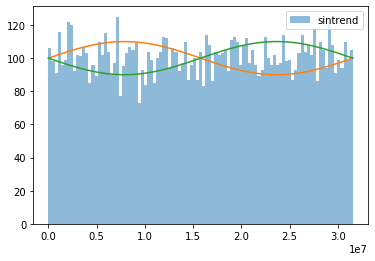

In [869]:
bins = np.linspace(0, 31536000, 100)



plt.hist(x, bins, alpha=0.5, label='sintrend')

plt.plot(bins, 100 + 10 * np.sin(bins/31536000*2*np.pi))

plt.plot(bins, 100 + 10 * -np.sin(bins/31536000*2*np.pi))


plt.legend(loc='upper right')
plt.show()

In [846]:
bins

array([0.000000e+00, 1.593600e+06, 3.187200e+06, 4.780800e+06,
       6.374400e+06, 7.968000e+06, 9.561600e+06, 1.115520e+07,
       1.274880e+07, 1.434240e+07, 1.593600e+07, 1.752960e+07,
       1.912320e+07, 2.071680e+07, 2.231040e+07, 2.390400e+07,
       2.549760e+07, 2.709120e+07, 2.868480e+07, 3.027840e+07,
       3.187200e+07, 3.346560e+07, 3.505920e+07, 3.665280e+07,
       3.824640e+07, 3.984000e+07, 4.143360e+07, 4.302720e+07,
       4.462080e+07, 4.621440e+07, 4.780800e+07, 4.940160e+07,
       5.099520e+07, 5.258880e+07, 5.418240e+07, 5.577600e+07,
       5.736960e+07, 5.896320e+07, 6.055680e+07, 6.215040e+07,
       6.374400e+07, 6.533760e+07, 6.693120e+07, 6.852480e+07,
       7.011840e+07, 7.171200e+07, 7.330560e+07, 7.489920e+07,
       7.649280e+07, 7.808640e+07, 7.968000e+07, 8.127360e+07,
       8.286720e+07, 8.446080e+07, 8.605440e+07, 8.764800e+07,
       8.924160e+07, 9.083520e+07, 9.242880e+07, 9.402240e+07,
       9.561600e+07, 9.720960e+07, 9.880320e+07, 1.0039

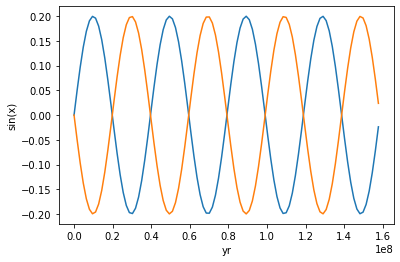

In [840]:
x = np.linspace(0, five_year_range, 100)
plt.plot(x,  .2* np.sin(x/31536000*5))
plt.plot(x,  .2* -np.sin(x/31536000*5))
plt.xlabel('yr')
plt.ylabel('sin(x)')
plt.axis('tight')
plt.show()

In [341]:
##### from datetime import datetime

now = datetime.now()
now_timestamp = datetime.timestamp(now)

five_years_ago = now.replace(year=2015)
five_years_ago_timestamp = datetime.timestamp(five_years_ago)

five_year_range = now_timestamp - five_years_ago_timestamp

arrestdates = []
incidentdates = []
sentencetermdays = []
sentencedurationyears = []
releasedates = []

for i in range(10):
    randtimestamp = np.random.randint(five_year_range) + five_years_ago_timestamp

    arrestdate = datetime.fromtimestamp(randtimestamp).strftime('%Y-%m-%d')
    incidentdate = datetime.fromtimestamp(randtimestamp - np.random.lognormal(0.3, 0.9, 1) * 86400).strftime('%Y-%m-%d')
    sentencetime = np.random.lognormal(0.5, 3, 1)[0] + 1
    releasedate = datetime.fromtimestamp(randtimestamp + sentencetime * 86400).strftime('%Y-%m-%d')
    sentenceyears = sentencetime//365
    
    
    
    arrestdates.append(arrestdate)
    incidentdates.append(incidentdate)
    sentencetermdays.append(round(sentencetime))
    sentencedurationyears.append(sentenceyears)
    releasedates.append(releasedate)
#     sentencetermdays = round(np.random.lognormal(0.3, 0.9, 1))
#     releasedates = "ASdf"

In [342]:
fake_justice_dt = pd.DataFrame({"IncidentDate": incidentdates, "ArrestDate": arrestdates, "ReleaseDate": releasedates, "SentenceTermDays": sentencetermdays, "SentenceDurationYrs":sentencedurationyears})

In [343]:
fake_justice_dt

,IncidentDate,ArrestDate,ReleaseDate,SentenceTermDays,SentenceDurationYrs
0,2015-04-05,2015-04-09,2015-04-28,19.0,0.0
1,2018-12-25,2018-12-26,2018-12-27,1.0,0.0
2,2015-04-19,2015-04-20,2017-07-06,808.0,2.0
3,2015-03-07,2015-03-09,2015-03-12,3.0,0.0
4,2015-12-21,2015-12-25,2015-12-28,3.0,0.0
5,2019-09-04,2019-09-04,2019-09-05,1.0,0.0
6,2015-11-14,2015-11-16,2015-11-20,3.0,0.0
7,2015-08-06,2015-08-08,2015-08-10,2.0,0.0
8,2017-07-29,2017-07-30,2017-08-18,19.0,0.0
9,2018-01-11,2018-01-13,2018-01-15,3.0,0.0


**health_datetimes**:

- TimeIn
- TimeOut
- EntryDateTime
- Age
- FollowupDate
- UpcomingApptScheduled
- LengthOfStayDays

**justice_datetimes**:

- IncidentDate
- ArrestDate
- ReleaseDate
- SentenceTermDays
- SentenceDurationYrs
- AgeAtBooking

## Make Data From Flight

In [20]:
with open('demohealth.yaml') as stream:
    stream = strip_constructors(stream.read())
    flight_dict = yaml.safe_load(stream)

In [21]:
flight_prop_columns = {}

for defn in flight_dict.keys():
    for ent in flight_dict[defn]:
        ent_fqn = flight_dict[defn][ent]['fqn']
        flight_prop_columns.update({ent_fqn: {}})
        for prop in flight_dict[defn][ent]['propertyDefinitions']:
            prop_dict = flight_dict[defn][ent]['propertyDefinitions'][prop]
            if 'column' in prop_dict:
                flight_prop_columns[ent_fqn].update({prop: prop_dict['column']})
            elif 'transforms' in prop_dict:
                if len(list(findkeys(prop_dict, 'columns')))  == 0:
                    flight_prop_columns[ent_fqn].update({prop: list(findkeys(prop_dict, 'column'))})
                else:
                    flight_prop_columns[ent_fqn].update({prop: list(findkeys(prop_dict, 'columns'))[0]})
            #flight_prop_columns[ent_fqn].update({prop:  {}})
              
        

In [22]:
from pandas.core.common import flatten
for k in flight_prop_columns.keys():
    index_cols = list(flight_prop_columns[k].values())[0]
    property_columns = set(flatten(list(flight_prop_columns[k].values())))
    
    try:
        property_col_df = existing_demohealth[property_columns]
        vc_list = [list(property_col_df[col].value_counts().items()) for col in property_col_df.columns]
            
    except KeyError:
        print(f"KeyError on {property_columns}")

    
    print(f"\n\n\n\n\n\nEntity:  {k}~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n\n\n\
Properties: {property_columns}  \n\n\
INDEX: {index_cols} \n\n\n\n\
Sample: \n\n{property_col_df.sample(1)}, \n\n\n\n\
Most common values of those cols: \n\n\n\n\n\n")
        
    for col in property_col_df.columns:
        print(f"{col} - Top 5 vcs: {vc_list[:5]}\n\n")
    
    







Entity:  general.person~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


Properties: {'ID', 'Ethnicity', 'Race', 'Sex', 'Birthdate', 'GivenName', 'FacilityName', 'Surname'}  

INDEX: ID 



Sample: 

    ID                                    Ethnicity    Race   Sex Birthdate GivenName FacilityName                        Surname  
130  29c67c2e-1b11-4141-b7e2-909387096eb9  nonhispanic  white  M   4/27/67   William   County Methadone Treatment Program  Alvarado, 



Most common values of those cols: 






ID - Top 5 vcs: [[('ffce8cd1-9c69-4dd5-b640-fdb8ff815eb15', 18), ('ca18962e-a0c1-401f-b171-b2435b696ff2', 14), ('29c67c2e-1b11-4141-b7e2-909387096eb9', 11), ('a8c72e41-2714-48b5-aff7-a8c6145e0e11', 8), ('ffce8c91-9c69-4dd5-b640-fdb8ff815eb15', 7), ('104844fe-835b-482b-9196-4ace6086739d', 7), ('1dddcaa1-32ae-49e7-9b68-0c0e909bab11', 6), ('ffce8c91-9c69-4dd5-b640-fdb8ff815eb12', 6), ('523e6174-2a49-4fdb-9ecc-be9d85dfc815', 5), ('a1821dd6-16a7-4485-9ece-c

In [46]:
existing_demohealth['NPI']

0      5.928376e+09
1      8.795827e+09
2      7.584738e+09
3      9.959484e+09
4      5.543453e+09
5      6.515767e+09
6      6.728375e+09
7      6.515767e+09
8      9.959484e+09
9      6.728375e+09
10     5.928376e+09
11     6.515767e+09
12     6.728375e+09
13     6.515767e+09
14     6.515767e+09
15     9.959484e+09
16     5.543453e+09
17     8.795827e+09
18     7.584738e+09
19     6.515767e+09
20     2.132711e+09
21     3.068795e+09
22     4.263965e+09
23     7.564576e+09
24     3.163258e+09
25     5.886478e+09
26     1.534427e+09
27     7.564543e+09
28     4.682319e+09
29     2.669766e+09
30     6.538860e+09
31     3.295050e+09
32     9.882095e+09
33     9.821172e+09
34     9.495877e+09
35     7.621688e+09
36     5.733960e+09
37     1.072465e+09
38     6.693444e+09
39     6.767428e+09
40     4.924789e+09
41     5.547299e+09
42     7.069392e+09
43     9.241794e+09
44     4.293544e+09
45     7.228967e+09
46     9.040833e+09
47     8.405354e+09
48     4.584582e+09
49     5.852600e+09


In [960]:
%ls

DemoData Generation.ipynb    demo_provider_employees.csv
LICENSE                      demo_providers.csv
README.md                    demobhr.yaml
app_bhr_processed.csv        democad.yaml
appointment_histories.csv    democad_skeleton.pdf
demo_alpr.csv                democad_verbose.pdf
demo_alpr.yaml               demohealth.yaml
demo_cad.csv                 demohealth_apphist.yaml
demo_health.csv              demojustice.yaml
demo_jail.yaml               demojustice_graph.png
demo_justice.csv


person -> is -> employee

employee -> works at -> provider

person -> contacted via -> contact information

employee -> contacted via -> contact information